<a href="https://colab.research.google.com/github/aritrasen87/LLM_From_Scratch/blob/main/2_Data_Batch_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
with open("input.txt", "r") as f:
    raw_text = f.read()

In [ ]:
import re

processed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text) ### split on punctuations
processed = [t for t in processed if t]   ### remove null tokens
print(processed[:20])

['First', ' ', 'Citizen', ':', '\n', 'Before', ' ', 'we', ' ', 'proceed', ' ', 'any', ' ', 'further', ',', ' ', 'hear', ' ', 'me', ' ']


In [ ]:
print("Number of tokens:", len(processed))

Number of tokens: 470358


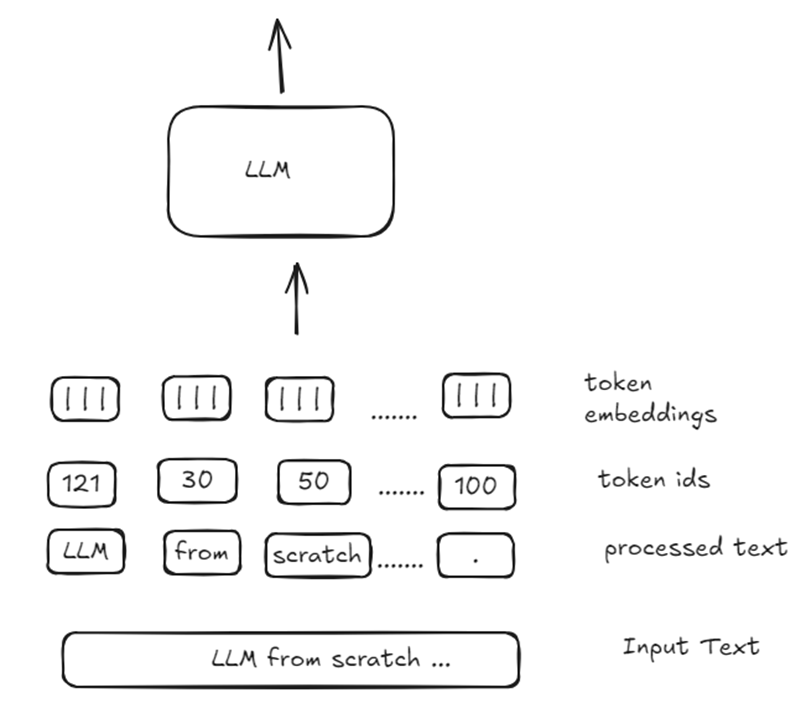

### Word Level Tokenizer - HelloWorldTokenizer

In [ ]:
all_unique_words = sorted(set(processed))

print(f"Vocabulary size: {(len(all_unique_words))}")

Vocabulary size: 13853


In [ ]:
vocabulary = {token : ix for ix , token in enumerate(all_unique_words)}

In [ ]:
vocabulary

{'\n': 0,
 ' ': 1,
 '!': 2,
 '&C': 3,
 '&c': 4,
 "'": 5,
 ',': 6,
 '--': 7,
 '.': 8,
 '3': 9,
 ':': 10,
 ';': 11,
 '?': 12,
 'A': 13,
 'ABHORSON': 14,
 'ABRAHAM': 15,
 'ADRIAN': 16,
 'AEacides': 17,
 'AEdile': 18,
 'AEdiles': 19,
 'AEneas': 20,
 'AEsop': 21,
 'ALL': 22,
 'ALONSO': 23,
 'ANGELO': 24,
 'ANNE': 25,
 'ANOTHER': 26,
 'ANTIGONUS': 27,
 'ANTONIO': 28,
 'ARCHBISHOP': 29,
 'ARCHIDAMUS': 30,
 'ARIEL': 31,
 'AUFIDIUS': 32,
 'AUMERLE': 33,
 'AUTOLYCUS': 34,
 'Abase': 35,
 'Abate': 36,
 'Abated': 37,
 'Abbot': 38,
 'Abel': 39,
 'Abhorred': 40,
 'Abhorson': 41,
 'Abides': 42,
 'Able': 43,
 'About': 44,
 'Above': 45,
 'Abraham': 46,
 'Absolute': 47,
 'Accept': 48,
 'Accomplish': 49,
 'According': 50,
 'Accords': 51,
 'Account': 52,
 'Accountant': 53,
 'Accursed': 54,
 'Accuse': 55,
 'Achieve': 56,
 'Acquaint': 57,
 'Action': 58,
 'Adam': 59,
 'Add': 60,
 'Added': 61,
 'Adding': 62,
 'Address': 63,
 'Adieu': 64,
 'Adjudged': 65,
 'Admit': 66,
 'Adonis': 67,
 'Adoptedly': 68,
 'Adopts'

In [ ]:
class HelloWorldTokenizer:
    def __init__(self, vocabulary):
        self.str_to_int = vocabulary
        self.int_to_str = {i:s for s,i in vocabulary.items()}

    def encode(self, text):
        processed = re.split(r'([,.?_!"()\']|--|\s)', text)
        processed = [
            t.strip() for t in processed if t.strip()
        ]
        token_ids = [self.str_to_int[s] for s in processed]
        return token_ids

    def decode(self, token_ids):
        text = " ".join([self.int_to_str[id] for id in token_ids])
        # Replace spaces before the punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [ ]:
text = "Let us kill him, and we'll have corn at our own price."
tokenizer = HelloWorldTokenizer(vocabulary)

token_ids = tokenizer.encode(text)

print(token_ids)

[1455, 13150, 8044, 7454, 6, 3177, 13443, 5, 8390, 7293, 4882, 3358, 9406, 9477, 10072, 8]


In [ ]:
tokenizer.decode(token_ids)

"Let us kill him, and we' ll have corn at our own price."

In [ ]:
text = "LLM from Scratch."
tokenizer = HelloWorldTokenizer(vocabulary)

token_ids = tokenizer.encode(text)

print(token_ids)

KeyError: 'LLM'

### BytePair Encoding (BPE) Tokenizer with tiktoken

- used in GPT2
- can handle unknow or new workds

In [ ]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
tokens = tokenizer.encode(raw_text)
print(f'Length of tokens : {len(tokens)}')
print(f'First few tokens: {tokens[:20]}')

Length of tokens : 338024
First few tokens: [5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248]


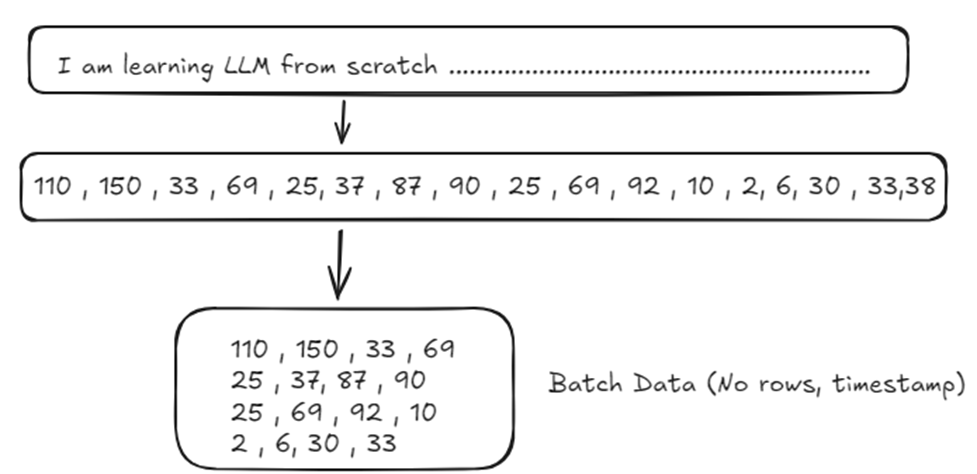


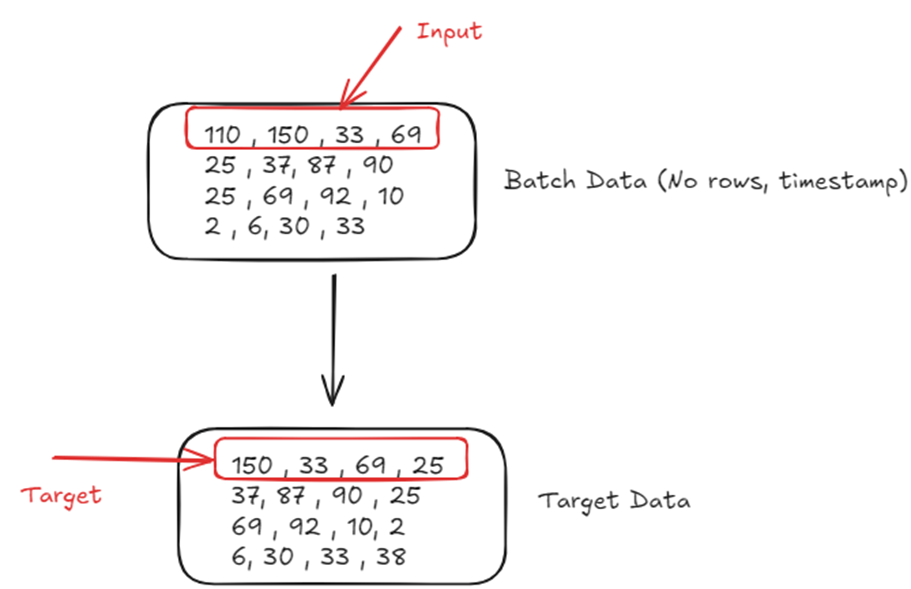

In [ ]:
import torch
buff = torch.tensor(tokens[:24])
x = buff.view(4,6)
print(x)

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])


In [ ]:
import torch
buff = torch.tensor(tokens[:25])
x = buff[:-1].view(4,6)   # batch_size , time_dim (context_length)
print(x)

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])


In [ ]:
y = buff[1:].view(4,6) # batch_size , time_dim (context_length)
print(y)

tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])


In [ ]:
### Adopted from Andrej Karpathy

import tiktoken

class GetBatches:
    def __init__(self , B , T) -> None:
        self.B = B # batch size
        self.T = T # time_dim or context length

        with open("input.txt", "r") as f:
            raw_text = f.read()

        tokenizer = tiktoken.get_encoding("gpt2")
        tokens = tokenizer.encode(raw_text)

        self.tokens = torch.tensor(tokens)

        print(f'Length of tokens : {len(self.tokens)}')
        print(f'One Epoch has : {len(self.tokens) // (B * T) } batches')

        self.current_position = 0

    def get_batch(self):

        buff = self.tokens[self.current_position : self.current_position + self.B*self.T+1]
        x = buff[:-1].view(self.B,self.T)
        y = buff[1:].view(self.B,self.T)

        self.current_position += self.B * self.T

        if self.current_position + (self.B * self.T + 1) > len(self.tokens):
            self.current_position = 0

        return x , y


In [ ]:
dataloader = GetBatches(B=4,T=6)

Length of tokens : 338024
One Epoch has : 14084 batches


In [ ]:
x , y = dataloader.get_batch()

In [ ]:
x

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])

In [ ]:
y

tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])